## VGG19 Custom

2021/ 05/ 17<br>
Deadline = 2021/05/23<br>
인공지능 부산반 정희석

**necessary condition**:<br>
⁠⁠Pytorch 라이브러리를 이용 (오른쪽 표 참고)<br>
**⁠Original VGG-19에서 FC 변형되었으니 주의바람!** <br> ⁠Dataset 구성:⁠Pytorch 에서 CIFAR10 dataset을 download 및 dataset 구성⁠ 전처리 및 augmentation:<br> **아래를 포함하도록 구성**⁠
- Transforms.RandomCrop(32, padding=4)
- ⁠Transforms.RandomHorizontalFlip()⁠
- Transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))⁠
- 각 Convolution 은 3x3 size, padding =1 로 둔다.⁠
- 각 Convolution 마다 batch normalization 및 Relu 추가
- ⁠Loss function: Cross Entropy loss⁠Optimization: Adam optimization(learning_rate = 0.001)⁠
- 마지막 FC layer는 FC-10이 되게 바꾼다.
- ⁠FC마다 dropout (p=0.2)를 추가한다. (마지막 FC 제외)⁠
- Batch size =100로 둔다.
- ⁠Epoch = 10  
- training 후에 ⁠test accuracy를 계산하여 화면에 print 한다.⁠
- Training 은 반드시 **gpu**에서 수행되도록 설정함.⁠
- 기타 hyper parameter는 자유롭게 정함.


 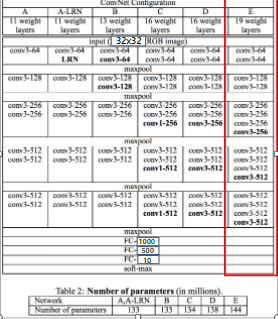

**필요한 모듈 import**

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torch
import torchvision
import torchvision.transforms as transforms

**데이터 다운로드 및 가공**

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomCrop(32, padding=4), # Condition 3-1.
     transforms.RandomHorizontalFlip(),    # Condition 3-2.
     transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))]) # Condition 3-3.

batch_size = 100 # Condition 10.
# Condition 2.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) # 다운로드 하면서 가공까지 완료.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2) # 학습용 데이터는 무작위성을 위해 shuffle를 진행.

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform) # 다운로드 하면서 가공까지 완료.
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2) # 테스트용 데이터는 shuffle를 할 필요가 없음.

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## **데이터 확인**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


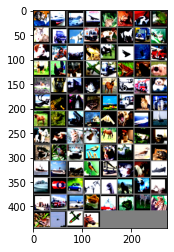

GroundTruth:    cat  ship  ship plane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader) 
images, labels = dataiter.next()


# 이미지를 출력합니다. # 테스트용 데이터 4개만 출력.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4))) 

**VGG CUSTOM**

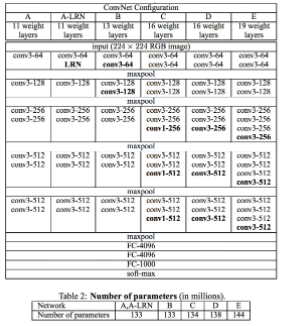

**VGGNet**은 2014년 ILSVRC에서 Oxford 대학교 Visual Geometry Group의 Karen Simonyan과 Andrew Zisserman이 제안한 모델이고,<br> GoogLeNet에 이어 2위를 차지했다. 하지만 GoogLeNet보다 구조적으로 간단하여 이해가 쉽고 테스트가 용이하기 때문에 더 많이 사용되었다.<br>
https://oi.readthedocs.io/en/latest/computer_vision/cnn/vggnet.html

In [ ]:
from typing import Union, List, Dict, Any, cast

In [ ]:
class VGG_custom(nn.Module): # model

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 10,
        init_weights: bool = True
    ) -> None:
        super(VGG_custom, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3)) # AdaptiveAvgPool2d
        self.classifier = nn.Sequential(
            nn.Linear(512 * 3 * 3, 1000),
            nn.ReLU(True),
            nn.Dropout(p=0.2), # Condition 9.
            nn.Linear(1000, 500),
            nn.ReLU(True),
            nn.Dropout(p=0.2), # Condition 9.
            nn.Linear(500, num_classes), # Condition 8.
            # 여기에서 Softmax가 들어가야 하는가? -> 일단 num_classes로 구별 되는 것 부터 Softmax의 역할을 하고 있기는 함.
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x) # CNN층
        x = self.avgpool(x) # 3차 -> 2차
        x = torch.flatten(x, 1) # 2차 -> 1차
        x = self.classifier(x) 
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [ ]:
cfgs : Dict[str, List[Union[str, int]]] = {
    'E':[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],} #각 층의 채널 개수
    # 3 => 64 -> 64 -> 128 -> 128 -> 256 -> 256 -> 256 -> 256 -> 512 -> 512 -> 512 -> 512 -> 512 -> 512 -> 512 -> 512 => 512,1,1 => 512*3*3 => 1000 -> 500 -> 10
    # Convolution Layer : 16개, Fully Connected Layer : 3개 => VGG19

In [ ]:
def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential: # convolution layer 생성
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)] # -> stride = 2, 필터가 2칸씩 이동. 크기가 1/2로 줄어듬.
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1) # Condition 4. => padding = 1로 둠으로써 zero_padding이 활성화. -> 크기 감소 X
            # nn.Conv2D(input_channels, output_channels, kernel_size)
            # parameter : stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros'
            # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)] # Condition 5.
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [ ]:
def _vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, **kwargs: Any) -> VGG_custom: # workhorse
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG_custom(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs) # model
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [ ]:
def vgg19_custom(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG_custom: # driver
    r"""VGG 19-layer model (configuration "E")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19', 'E', True, pretrained, progress, **kwargs)

In [ ]:
import torch.optim as optim
vgg_cu = vgg19_custom() #신경망
criterion = nn.CrossEntropyLoss() #손실함수 # Condition 6.
optimizer = optim.Adam(vgg_cu.parameters()) #최적화함수 Condition 7.

**torch 모델 구성 확인**

https://gaussian37.github.io/dl-pytorch-observe/

In [ ]:
!pip install torchinfo
from torchinfo import summary
from torchvision import models

summary(vgg_cu, (10, 3, 32, 32)) #신경망 모델 확인하기

Layer (type:depth-idx)                   Output Shape              Param #
VGG_custom                               --                        --
├─Sequential: 1-1                        [10, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [10, 64, 32, 32]          1,792
│    └─BatchNorm2d: 2-2                  [10, 64, 32, 32]          128
│    └─ReLU: 2-3                         [10, 64, 32, 32]          --
│    └─Conv2d: 2-4                       [10, 64, 32, 32]          36,928
│    └─BatchNorm2d: 2-5                  [10, 64, 32, 32]          128
│    └─ReLU: 2-6                         [10, 64, 32, 32]          --
│    └─MaxPool2d: 2-7                    [10, 64, 16, 16]          --
│    └─Conv2d: 2-8                       [10, 128, 16, 16]         73,856
│    └─BatchNorm2d: 2-9                  [10, 128, 16, 16]         256
│    └─ReLU: 2-10                        [10, 128, 16, 16]         --
│    └─Conv2d: 2-11                      [10, 128, 16, 16]         147,

### with gpu

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Condition 12.

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cuda:0


In [ ]:
vgg_cu.to(device)

VGG_custom(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(1

**<h3> 학습 진행 </h3>**

In [ ]:
for epoch in range(10):   # 데이터셋을 수차례 반복합니다.
    print('epoch:',epoch)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = vgg_cu(inputs) # 데이터를 모델에 통과하여 결과 예측(순전파)
        loss = criterion(outputs, labels) # 해당 결과를 기반으로 오류 검사
        loss.backward()  # 손실을 바탕으로 역전파 진행 
        optimizer.step() # 최적화 진행

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 100 == 99:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

epoch: 0
[1,   100] loss: 2.171
[1,   200] loss: 1.931
[1,   300] loss: 1.881
[1,   400] loss: 1.849
[1,   500] loss: 1.784
epoch: 1
[2,   100] loss: 1.734
[2,   200] loss: 1.686
[2,   300] loss: 1.707
[2,   400] loss: 1.622
[2,   500] loss: 1.570
epoch: 2
[3,   100] loss: 1.524
[3,   200] loss: 1.491
[3,   300] loss: 1.437
[3,   400] loss: 1.384
[3,   500] loss: 1.363
epoch: 3
[4,   100] loss: 1.278
[4,   200] loss: 1.228
[4,   300] loss: 1.186
[4,   400] loss: 1.163
[4,   500] loss: 1.109
epoch: 4
[5,   100] loss: 1.082
[5,   200] loss: 1.060
[5,   300] loss: 1.033
[5,   400] loss: 1.005
[5,   500] loss: 1.006
epoch: 5
[6,   100] loss: 0.932
[6,   200] loss: 0.943
[6,   300] loss: 0.942
[6,   400] loss: 0.903
[6,   500] loss: 0.898
epoch: 6
[7,   100] loss: 0.841
[7,   200] loss: 0.831
[7,   300] loss: 0.822
[7,   400] loss: 0.833
[7,   500] loss: 0.783
epoch: 7
[8,   100] loss: 0.761
[8,   200] loss: 0.775
[8,   300] loss: 0.744
[8,   400] loss: 0.741
[8,   500] loss: 0.733
epoch: 8

In [ ]:
dataiter = iter(testloader) # 테스트 데이터 불러오기
images, labels = dataiter.next()
correct = 0
total = 0
with torch.no_grad(): # 이 부분은 CIFAR 튜토리얼에서 사용한 방식 그대로.
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) #to device : cpu용 tensor -> gpu(cuda)용 tensor로 변환
        outputs = vgg_cu(images) # 예측 진행.
        _, predicted = torch.max(outputs.data, 1) #여기 max가 softmax의 역할을 한다...?
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 78 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) #to device : cpu용 tensor -> gpu(cuda)용 tensor로 변환
        outputs = vgg_cu(images) # 예측 진행.
        _, predicted = torch.max(outputs, 1) # classify
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 88 %
Accuracy of   car : 87 %
Accuracy of  bird : 60 %
Accuracy of   cat : 69 %
Accuracy of  deer : 79 %
Accuracy of   dog : 59 %
Accuracy of  frog : 86 %
Accuracy of horse : 90 %
Accuracy of  ship : 89 %
Accuracy of truck : 93 %


### Deprecate

#### checkpoint?

In [ ]:
PATH = './cifar_vgg_cu_20.pth' # 학습 가중치 값을 dict 형식으로 저장. 
torch.save(vgg_cu.state_dict(), PATH) # state_dict 는 간단히 말해 각 계층을 매개변수 텐서로 매핑되는 Python 사전(dict) 객체입니다. 
# https://tutorials.pytorch.kr/beginner/saving_loading_models.html

In [ ]:
for epoch in range(10):   # 데이터셋을 수차례 반복합니다.
    print('epoch:',epoch)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = vgg_cu(inputs) # 데이터를 모델에 통과하여 결과 예측(순전파)
        loss = criterion(outputs, labels) # 해당 결과를 기반으로 오류 검사
        loss.backward()  # 손실을 바탕으로 역전파 진행 
        optimizer.step() # 최적화 진행

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 100 == 99:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        if epoch > 1 and epoch % 10 == 0 :
            PATH = './cifar_vgg_cu_{epoch:02d}-{running_loss:.4f}.pth'
            torch.save(vgg_cu.state_dict(), PATH)

print('Finished Training')

#### CPU

**cpu로 하면 너무 느리다!!**

40분을 했는데도 학습이 진행 안됬었음.

In [ ]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = vgg_cu(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
PATH = './cifar_vgg_cu.pth'
torch.save(vgg_cu.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))